In [1]:
#IMPORTACIÓN DE LIBRERÍAS PERTINENTES
%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim #IDK HOW TO USE THIS [!]
from tqdm import tqdm #progress bar
import scipy.stats as stats

In [2]:
#CARACTERIZACIÓN
#CÁLCULO: [ARRAY HISTORIAL POSICIONES](SLICING); [ARRAY HISTORIAL VELOCIDADES](SLICING), [ARRAY TIEMPOS EN QUE DIST i ES MENOR QUE DIST VECINOS]
#RETURN: [GetPosition->self.R]; [GetVelocity->self.V]; [GetPerihelio->timeup]
class Planeta:

    #CARACTERIZACIÓN INICIAL DEL PLANETA
    def __init__(self, e, a, t):

        self.t = t #array definido de 0 a tmax en pasos dt
        self.dt = t[1] - t[0] # Paso del tiempo

        self.e = e # Excentricidad
        self.a_ = a # Semi-eje mayor

        self.G = 4*np.pi**2 # Unidades gaussianas

        self.r = np.zeros(3) # (vacío) posición instantánea en x, y, z
        self.v = np.zeros_like(self.r) # (vacío) velocidad instantánea en x, y, z
        self.a = np.zeros_like(self.r) # (vacío) aceleración instantánea en x, y, z

        self.r[0] = self.a_*(1-self.e) # posición inicial en x
        self.v[1] = np.sqrt( self.G*(1+self.e)/(self.a_*(1.-self.e)) ) # velocidad inicial en y

        self.R = np.zeros((len(t),len(self.r))) # array de posiciones históricas
        self.V = np.zeros_like(self.R) # array de velocidades históricas

        self.rp = self.r # posición inicial como pasada

    #CÁLCULO DE ACELERACIÓN INSTANTÁNEA
    def GetAceleration(self):

        d = np.linalg.norm(self.r)
        self.a = -self.G/d**3*self.r #r es 0 en (y, z), so???????

    #CÁLCULO DE POSICIÓN INSTANTÁNEA EN TIEMPO i > REGISTRO EN EL HISTORIAL
    #CÁLCULO DE VELOCIDAD INSTANTÁNEA EN TIEMPO i > REGISTRO EN EL HISTORIAL
    def Evolution(self,i):

        self.SetPosition(i) #histórico de posiciones en i
        self.SetVelocity(i) #histórico de velocidades en i
        self.GetAceleration() #cálculo instantáneo de aceleración

        if i==0: #¿porqué se deja fuera la posición inicial?
            self.r = self.rp + self.v*self.dt #Euler para la primera
        else:

            # rp pasado; r presente; rf futuro
            self.rf = 2*self.r - self.rp + self.a*self.dt**2 #¿qué método es este?
            self.v = (self.rf - self.rp)/(2*self.dt) #¿porqué rf y rp, y no rf y r?

            self.rp = self.r #el anterior como pasado
            self.r = self.rf # el nuevo como presente > histórico de posición en i

    #POSICIÓN EN i
    def SetPosition(self,i):
        self.R[i] = self.r

    #VELOCIDAD EN i
    def SetVelocity(self,i):
        self.V[i] = self.v

    #SLICE HISTÓRICO DE POSICIONES > CADA (SCALE) ELEMENTOS
    def GetPosition(self,scale=1):
        return self.R[::scale]

    #SLICE HISTÓRICO DE VELOCIDADES > CADA (SCALE) ELEMENTOS
    def GetVelocity(self,scale=1):
        return self.V[::scale]

    #TIEMPOS i EN QUE LA DISTANCIA AL CENTRO (SOL) ES MENOR QUE EN LOS VECINOS
    def GetPerihelio(self):

        Dist = np.linalg.norm(self.R,axis=1) #¿axis? #array de las normas de cada histórico de posición

        timeup = []

        for i in range(1,len(Dist)-1): #no se toma en cuenta la primera o la última distancia, no tienen dos vecinos para comparar
            if Dist[i] < Dist[i-1] and Dist[i] < Dist[i+1]: #si norma i es menor a norma vecinos
                timeup.append(self.t[i]) #en el tiempo i se encuentra en  una punta de la elipse ¿cuál?

        return timeup

In [3]:
#CARACTERIZACIÓN TEMPORAL
dt = 0.001 #paso temporal
tmax = 50
t = np.arange(0.,tmax,dt)

# **(a) Tome los semi-ejes mayores y excentricidad de Internet.**

In [4]:
#CÁLCULO: [LISTA DE PLANETAS COMO CLASS PLANETA]
#RETURN: [lista sin nombre] -> [Planetas]
def GetPlanetas(t):

    Mercurio = Planeta(0.2056, 0.3870, t)
    Venus = Planeta(0.0067, 0.7233, t)
    Tierra = Planeta(0.0167, 1., t)
    Marte = Planeta(0.0933, 1.5236, t)
    Júpiter = Planeta(0.0487, 5.2042, t)

    return [Mercurio,Venus,Tierra, Marte, Júpiter]


In [5]:
#LISTA DE PLANETAS COMO CLASS PLANETA
Planetas = GetPlanetas(t)

In [6]:
#CÁLCULO: [HISTORIAL POSICIONES]; [HISTORIAL VELOCIDADES] -> PARA TODOS LOS PLANETAS
#RETURN: [BARRA DE PROGRESO]; [NO GUARDA POSICIONES NI VELOCIDADES DE PLANETAS] [?] -> [Planetas] ¿Queda almacenado?
def RunSimulation(t,Planetas):

    for it in tqdm(range(len(t)), desc='Running simulation', unit=' Steps' ): #progress bar [?]

        for i in range(len(Planetas)): #por cada planeta de la lista
            Planetas[i].Evolution(it) #calcular historial de posiciones e historial de velocidades #¿it? [?]

    return Planetas #why return Planetas again?

In [7]:
#BARRA DE PROGRESO
Planetas = RunSimulation(t,Planetas)

Running simulation: 100%|██████████| 50000/50000 [00:03<00:00, 14576.77 Steps/s]


# **(b) Calcule el periodo de la órbita usando el perihelio o el afelio.**

In [8]:
#CÁLCULO: [ARRAY DE PERIODOS DE PLANETAS]
#RETURN: [periodos]
def GetPeriodos(Planetas):

  periodos = np.zeros(len(Planetas))

  for i in range(len(Planetas)): #por cada planeta de la lista
      tiempos_reducción_distancia = Planetas[i].GetPerihelio() #calcular la lista de tiempos en que hay una reducción de la distancia al sol
      periodo = tiempos_reducción_distancia[1] - tiempos_reducción_distancia[0] #calcular periodo como ¿(2-0) o (1-0)? [?]
      periodos[i] = periodo #añadir periodo calculado a la lista

  return periodos

In [9]:
#ARRAY DE PERIODOS DE PLANETAS
periodos = GetPeriodos(Planetas)

#REPORTE DE PERIODOS DE PLANETAS
lista_planetas = ["Mercurio","Venus","Tierra", "Marte", "Júpiter"]
for i in range(len(lista_planetas)):
    reporte = "El periodo orbital de " + lista_planetas[i] + " es de " + str(round(periodos[i],2)) + " años terrestres."
    print(reporte)

El periodo orbital de Mercurio es de 0.24 años terrestres.
El periodo orbital de Venus es de 0.62 años terrestres.
El periodo orbital de Tierra es de 1.0 años terrestres.
El periodo orbital de Marte es de 1.88 años terrestres.
El periodo orbital de Júpiter es de 11.87 años terrestres.


# **(c) Grafique el periodo al cuadrado (T^2) en función del semi-eje mayor al cubo (a_^3) de cada planeta.**

# **(d) Usando el curso de métodos I, haga la regresión lineal para encontrar pendiente y punto de corte.**

La pendiente de la regresión lineal sobre [(T^2) vs. (a_**3)] es de 1.0
El intercepto de la regresión lineal sobre [(T^2) vs. (a_**3)] es de 0.0


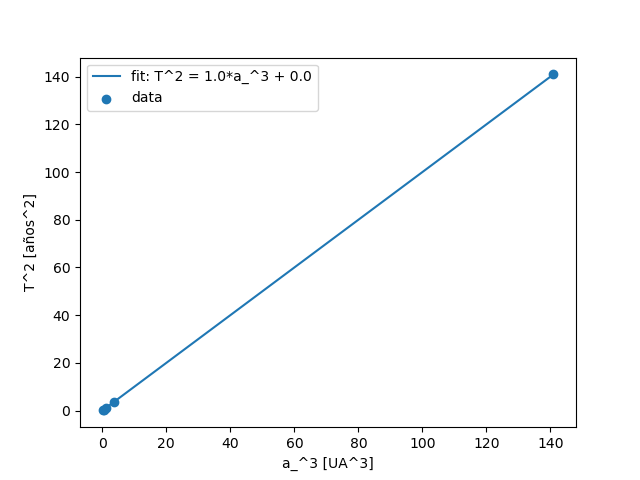

In [10]:
#ARRAY DE SEMIEJES MAYORES AL CUBO
semiejes_mayores_cubo = np.zeros(len(Planetas))
for i in range(len(Planetas)):
    semiejes_mayores_cubo[i] = Planetas[i].a_**3

#ARRAY DE PERIODOS AL CUADRADO
periodos_cuadrado = np.zeros(len(Planetas))
for i in range(len(Planetas)):
    periodos_cuadrado[i] = periodos[i]**2

#REGRESIÓN LINEAL
regresión_lineal = stats.linregress(semiejes_mayores_cubo, periodos_cuadrado)
pendiente = regresión_lineal.slope
intercepto = regresión_lineal.intercept

print("La pendiente de la regresión lineal sobre [(T^2) vs. (a_**3)] es de " + str(round(pendiente,2)))
print("El intercepto de la regresión lineal sobre [(T^2) vs. (a_**3)] es de " + str(round(intercepto,2)))

#GRÁFICO: [(T^2) vs. (a_^3)] PARA CADA PLANETA
plt.figure()
plt.scatter(semiejes_mayores_cubo, periodos_cuadrado, label="data")
plt.plot(semiejes_mayores_cubo, pendiente*semiejes_mayores_cubo+intercepto, label="fit: T^2 = "+str(round(pendiente,2))+"*a_^3 + "+str(round(intercepto,2)))
plt.xlabel("a_^3 [UA^3]")
plt.ylabel("T^2 [años^2]")
plt.legend()
plt.show()

# **(e) Con el valor de la pendiente, reporte la masa del sol en unidades gausiana y en el sistema internacional SI.**

In [11]:
#CÁLCULO: MASA DEL SOL EN UNIDADES GAUSSIANAS Y EN SI
masa_sol_gaussianas = 1/pendiente #por 3° ley de Kepler con G en unidades Gaussianas

G_SI = 6.67 * (10**(-11)) #N(m^2)/Kg
pendiente_SI = pendiente * (9.95*(10**14)) / (3.34*(10**33)) #(s^2)/(m^3)
masa_sol_SI = (4*(np.pi)**2)/(G_SI*pendiente_SI)

print("La masa del sol en unidades Gaussianas corresponde a "+str(round(masa_sol_gaussianas,2))+ " masas solares")
print("La masa del sol en unidades del Sistema Internacional corresponde a: "+str(round(masa_sol_SI,0))+ " Kg")

La masa del sol en unidades Gaussianas corresponde a 1.0 masas solares
La masa del sol en unidades del Sistema Internacional corresponde a: 1.986883843178928e+30 Kg
